In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/home-credit-default-risk/sample_submission.csv
/kaggle/input/home-credit-default-risk/bureau_balance.csv
/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv
/kaggle/input/home-credit-default-risk/application_train.csv
/kaggle/input/home-credit-default-risk/HomeCredit_columns_description.csv
/kaggle/input/home-credit-default-risk/application_test.csv
/kaggle/input/home-credit-default-risk/previous_application.csv
/kaggle/input/home-credit-default-risk/credit_card_balance.csv
/kaggle/input/home-credit-default-risk/installments_payments.csv
/kaggle/input/home-credit-default-risk/bureau.csv


In [2]:
dir_ref = "/kaggle/input/home-credit-default-risk/"

app_train = pd.read_csv(dir_ref + "application_train.csv")
POS_CASH_balance = pd.read_csv(dir_ref + "POS_CASH_balance.csv")
bureau_balance = pd.read_csv(dir_ref + "bureau_balance.csv")
previous_application = pd.read_csv(dir_ref + "previous_application.csv")
installments_payments = pd.read_csv(dir_ref + "installments_payments.csv")
credit_card_balance = pd.read_csv(dir_ref + "credit_card_balance.csv")
bureau = pd.read_csv(dir_ref + "bureau.csv")
app_test = pd.read_csv(dir_ref + "application_test.csv")

In [3]:
print('Size of application_train data', app_train.shape)
print('Size of application_test data', app_test.shape)
print('Size of POS_CASH_balance data', POS_CASH_balance.shape)
print('Size of bureau_balance data', bureau_balance.shape)
print('Size of previous_application data', previous_application.shape)
print('Size of installments_payments data', installments_payments.shape)
print('Size of credit_card_balance data', credit_card_balance.shape)
print('Size of bureau data', bureau.shape)

Size of application_train data (307511, 122)
Size of application_test data (48744, 121)
Size of POS_CASH_balance data (10001358, 8)
Size of bureau_balance data (27299925, 3)
Size of previous_application data (1670214, 37)
Size of installments_payments data (13605401, 8)
Size of credit_card_balance data (3840312, 23)
Size of bureau data (1716428, 17)


In [4]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

<AxesSubplot:ylabel='Frequency'>

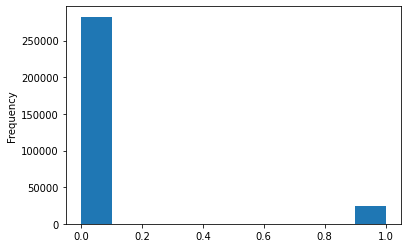

In [5]:
app_train['TARGET'].astype(int).plot.hist()

欠損値の確認

In [6]:
def missing_values_table(df):
    
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
         "There are " + str(mis_val_table_ren_columns.shape[0]) +
         " columns that have missing values.")
    
    return mis_val_table_ren_columns

In [7]:
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [8]:
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

pandas.DataFrameのメソッドselect_dtypes()を使うことで特定のデータ型dtypeの列だけを抽出できる

文字列strを要素とする列のデータ型dtypeはobject

pandas.Series.unique()：ユニークな要素の値のリストをNumPy配列ndarrayで返す

In [9]:
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

2種類の文字列で表されている列に関してone-hot表現に変換

In [10]:
le = LabelEncoder()
le_count = 0

for col in app_train:
    if app_train[col].dtype == 'object':
        if len(list(app_train[col].unique())) <= 2:
            le.fit(app_train[col])
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            le_count += 1

print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


カテゴリ変数をダミー変数に変換

In [11]:
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


shapeを比較すると、trainingが243行、testingが239行

TARGETの予測する列以外がtrainとtestで共通するように加工

In [12]:
train_labels = app_train['TARGET']
# ここでapp_trainの形をapp_testに合わせる
app_train, app_test = app_train.align(app_test, join='inner', axis=1)
# 最後にTARGETの列を追加
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


In [13]:
app_train['DAYS_BIRTH']

0         -9461
1        -16765
2        -19046
3        -19005
4        -19932
          ...  
307506    -9327
307507   -20775
307508   -14966
307509   -11961
307510   -16856
Name: DAYS_BIRTH, Length: 307511, dtype: int64

DAY_BIRTHはデータを取った日から何日前に生まれたかを表している？

In [14]:
(app_train['DAYS_BIRTH'] / -365).describe()  # describeで各列の要約統計量（平均、標準偏差など）を取得できる

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [15]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

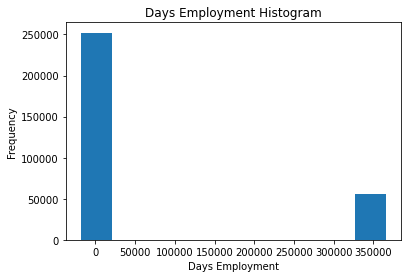

In [16]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [17]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


Text(0.5, 0, 'Days Employment')

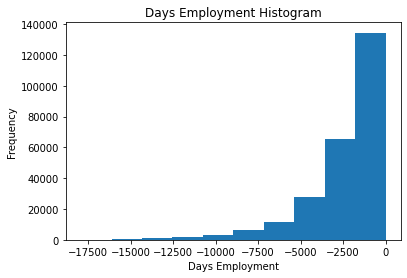

In [18]:
app_train['DAYS_EMPLOYED_ANOM'] = app_train['DAYS_EMPLOYED'] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment')

In [19]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


In [20]:
correlations = app_train.corr()['TARGET'].sort_values()

print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlatios:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

In [21]:
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982694

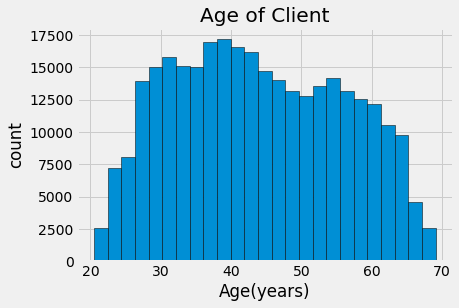

In [22]:
plt.style.use('fivethirtyeight')

plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client');
plt.xlabel('Age(years)');
plt.ylabel('count');


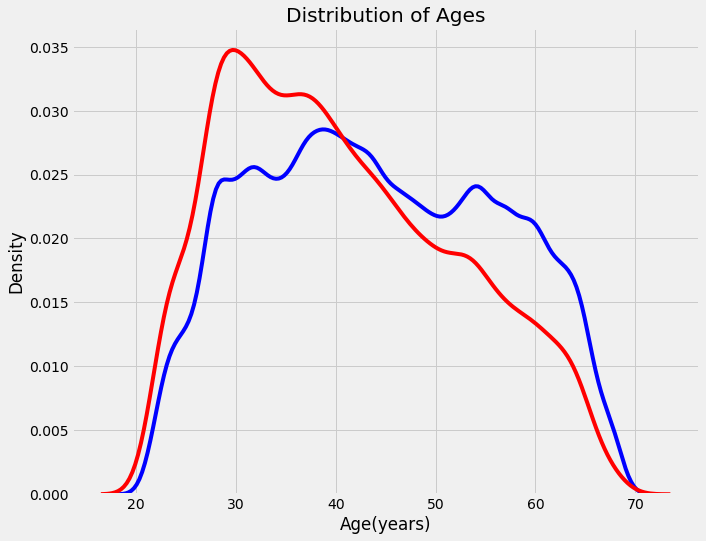

In [23]:
plt.figure(figsize=(10,8))

sns.kdeplot(app_train.loc[app_train['TARGET']==0, 'DAYS_BIRTH']/365, label='target == 0', color="b")
sns.kdeplot(app_train.loc[app_train['TARGET']==1, 'DAYS_BIRTH']/365, label='target == 1', color="r")

plt.xlabel('Age(years)');
plt.ylabel('Density');
plt.title('Distribution of Ages');

不履行の集団は年齢が若い傾向にある

In [24]:
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH']/365

age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(20)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [25]:
age_groups = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


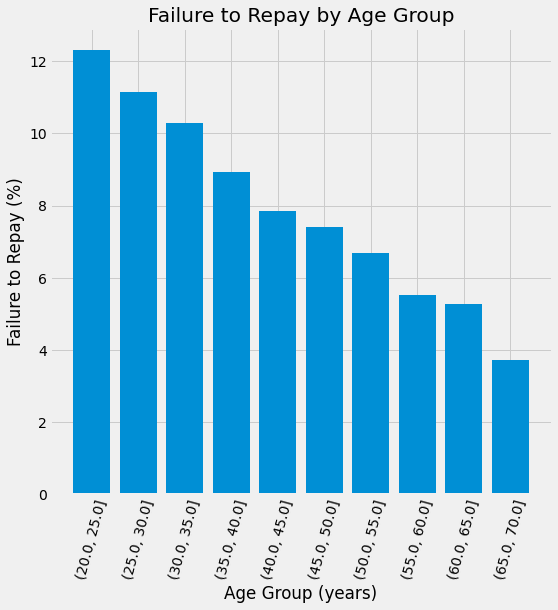

In [26]:
plt.figure(figsize = (8, 8))

plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

plt.xticks(rotation = 75);
plt.xlabel('Age Group (years)');
plt.ylabel('Failure to Repay (%)');
plt.title('Failure to Repay by Age Group');


年齢が若いほど不履行の割合が高い

In [27]:
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]  # 外部データソースからの正規化スコア
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


Text(0.5, 1.0, 'Correlation Heatmap')

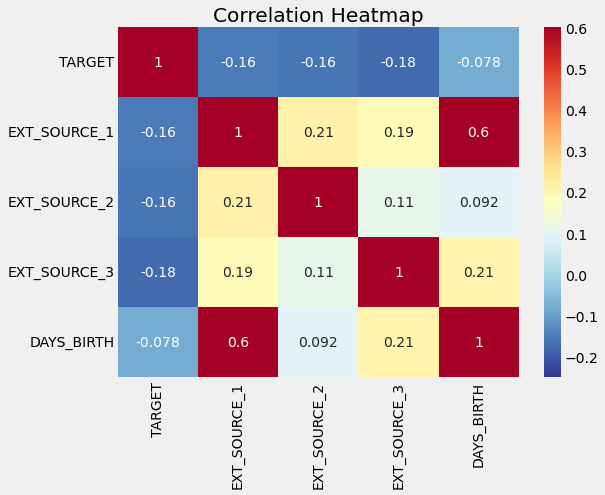

In [28]:
plt.figure(figsize=(8, 6))

sns.heatmap(ext_data_corrs, cmap=plt.cm.RdYlBu_r, vmin=-0.25, annot=True, vmax=0.6)
plt.title('Correlation Heatmap')

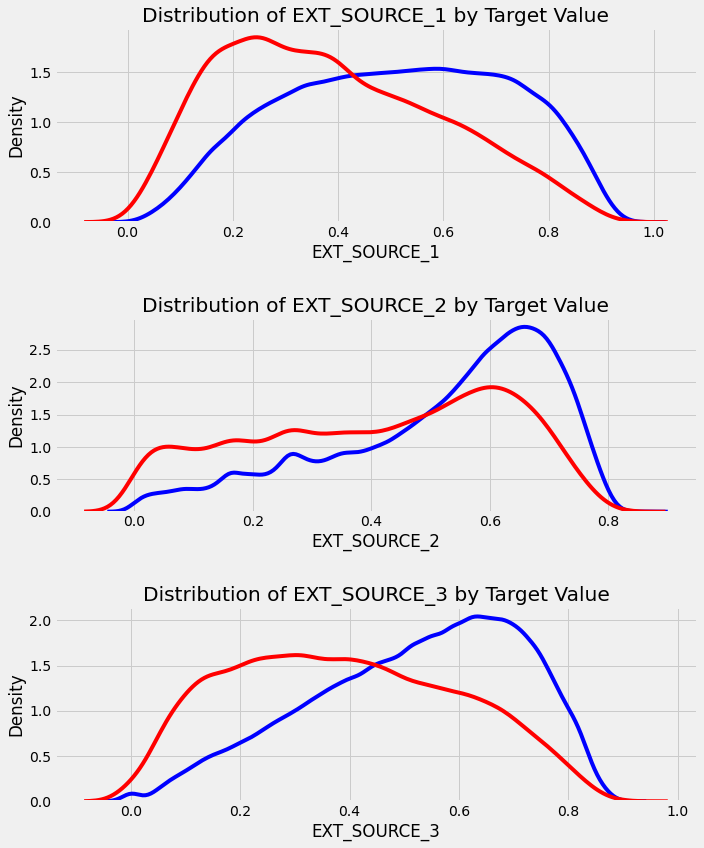

In [29]:
plt.figure(figsize=(10,12))

for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    plt.subplot(3, 1, i + 1)
    
    sns.kdeplot(app_train.loc[app_train['TARGET']==0, source], label='target==0', color="b")
    sns.kdeplot(app_train.loc[app_train['TARGET']==1, source], label='target==1', color="r")
    
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source);
    plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

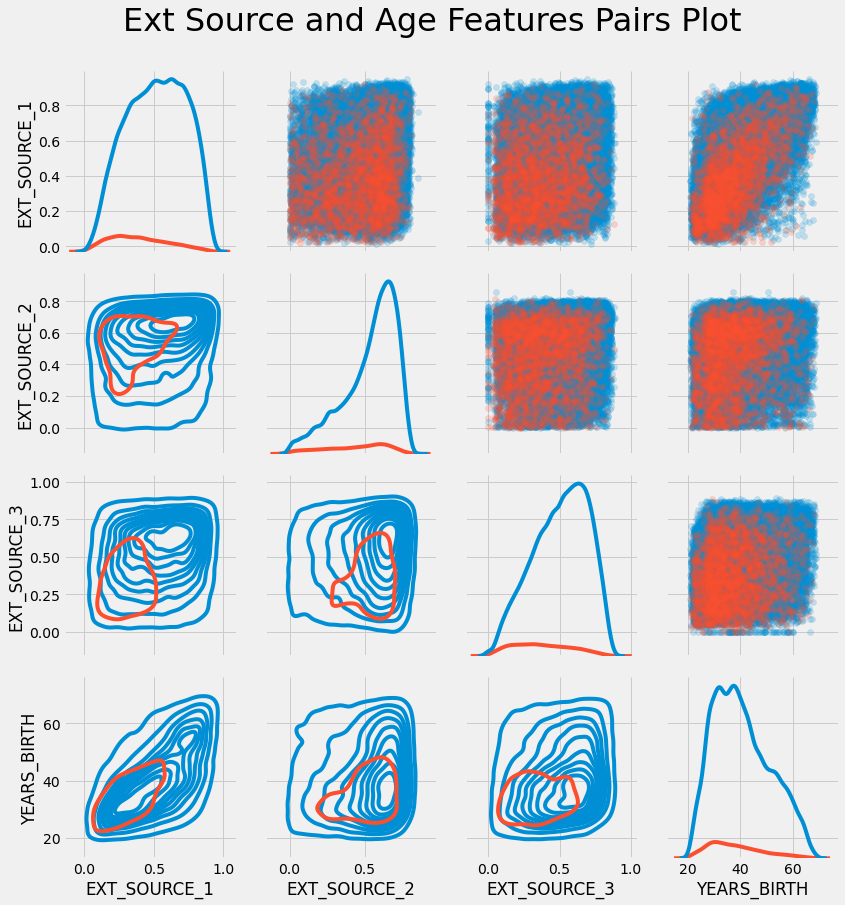

In [30]:
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

plot_data = plot_data.dropna().loc[:100000, :]

def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
               xy = (.2, .8), xycoords = ax.transAxes,
               size = 20)
    
grid = sns.PairGrid(data = plot_data, size = 3, diag_sharey=False,
                   hue = 'TARGET',
                   vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

grid.map_upper(plt.scatter, alpha=0.2)
grid.map_diag(sns.kdeplot)
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);
plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);


In [31]:
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')

poly_target = poly_features['TARGET']
poly_features = poly_features.drop(columns = ['TARGET'])

poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures

poly_transformer = PolynomialFeatures(degree=3)

In [32]:
poly_transformer.fit(poly_features)

poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


In [33]:
poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2']

In [34]:
poly_features = pd.DataFrame(poly_features,columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']))
poly_features['TARGET'] = poly_target

poly_corrs = poly_features.corr()['TARGET'].sort_values()

print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


In [35]:
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
app_test_poly = app_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)

print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

Training data with polynomial features shape:  (307511, 275)
Testing data with polynomial features shape:   (48744, 275)


In [36]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

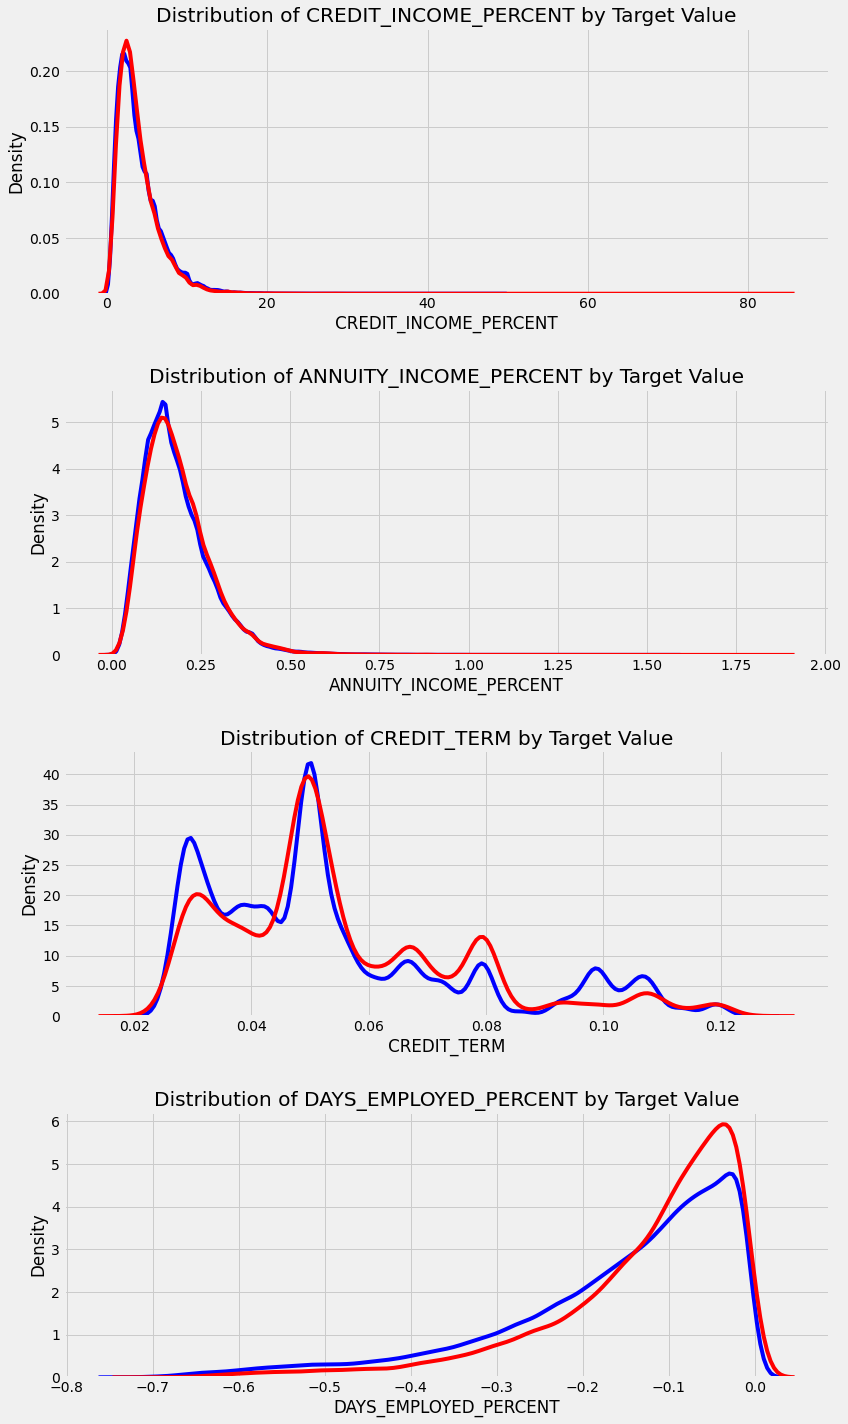

In [37]:
plt.figure(figsize=(12,20))

for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    plt.subplot(4, 1, i+1)
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET']==0, feature], label='target==0', color="b")
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET']==1, feature], label='target==1', color="r")
    
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature);
    plt.ylabel('Density');

plt.tight_layout(h_pad = 2.5)

In [38]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

if 'TARGET' in app_train:
    train = app_train.drop(columns = ['TARGET'])
else:
    train = app_train.copy()
    
features = list(train.columns)
test = app_test.copy()
imputer = SimpleImputer(strategy = 'median')
scaler = MinMaxScaler(feature_range = (0, 1))

imputer.fit(train)

train = imputer.transform(train)
test = imputer.transform(app_test)

scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape:', train.shape)
print('Testing data shape:', test.shape)

Training data shape: (307511, 240)
Testing data shape: (48744, 240)


In [39]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(C = 0.0001)
log_reg.fit(train, train_labels)

LogisticRegression(C=0.0001)

In [40]:
log_reg_pred = log_reg.predict_proba(test)[:, 1]

In [41]:
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred

submit.head()

,SK_ID_CURR,TARGET
0,100001,0.078515
1,100005,0.137926
2,100013,0.082194
3,100028,0.080921
4,100038,0.132618


In [42]:
submit.to_csv('log_reg_baseline.csv', index = False)

In [43]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

In [44]:
random_forest.fit(train, train_labels)

feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

predictions = random_forest.predict_proba(test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.9s finished


In [45]:
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

submit.to_csv('random_forest_baseline.csv', index = False)

In [46]:
poly_features_names = list(app_train_poly.columns)

imputer = SimpleImputer(strategy = 'median')

poly_features = imputer.fit_transform(app_train_poly)
poly_features_test = imputer.transform(app_test_poly)

scaler = MinMaxScaler(feature_range = (0,1))

poly_features = scaler.fit_transform(poly_features)
poly_features_test = scaler.transform(poly_features_test)

random_forest_poly = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

In [47]:
random_forest_poly.fit(poly_features, train_labels)

predictions = random_forest_poly.predict_proba(poly_features_test)[:,1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   51.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished


In [48]:
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

submit.to_csv('random_forest_baseline_engineered.csv', index = False)

In [49]:
app_train_domain = app_train_domain.drop(columns = 'TARGET')

domain_features_names = list(app_train_domain.columns)

imputer = SimpleImputer(strategy = 'median')

domain_features = imputer.fit_transform(app_train_domain)
domain_features_test = imputer.transform(app_test_domain)

scaler = MinMaxScaler(feature_range = (0,1))

domain_features = scaler.fit_transform(domain_features)
domain_features_test = scaler.transform(domain_features_test)

random_forest_domain = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

random_forest_domain.fit(domain_features, train_labels)

feature_importance_value_domain = random_forest_domain.feature_importances_
feature_importances_domain = pd.DataFrame({'feature': domain_features_names, 'importance': feature_importance_value_domain})

predictions = random_forest_domain.predict_proba(domain_features_test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.8s finished


In [50]:
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

submit.to_csv('random_forest_baseline_domain.csv', index = False)

In [51]:
def plot_feature_importances(df):
    
    df = df.sort_values('importance', ascending = False).reset_index()
    
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    ax.barh(list(reversed(list(df.index[:15]))),
           df['importance_normalized'].head(15),
           align = 'center', edgecolor = 'k')
    
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    plt.xlabel('Normalized Importance');
    plt.title('Feature Importances');
    plt.show()
    
    return df

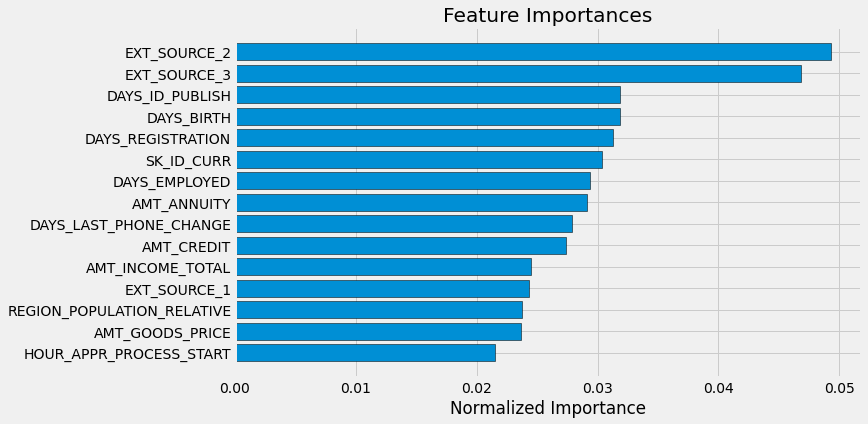

In [52]:
feature_importances_sorted = plot_feature_importances(feature_importances)